Genes 246
Windows 2458
TFs 262
Metacells 2795
Epochs 500
Batch Size 32
d_model 384
Attention Heads 6
Model Layers 3
d_feedforward 768
Dropout 0.1
Distance Bias Yes

Overlap TFs: 135 / 262
Overlap TGs: 57 / 246


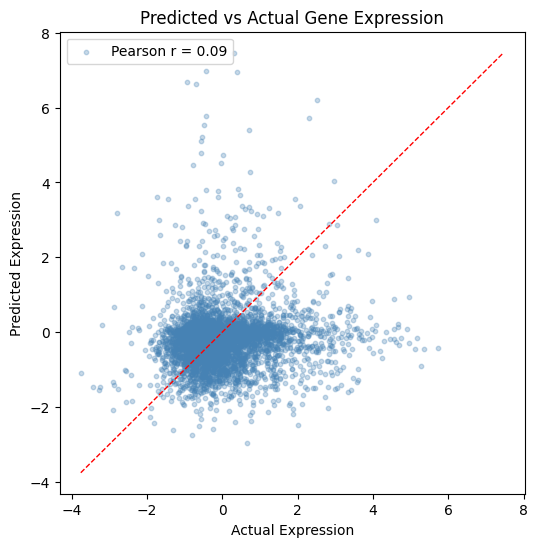

             gene   pearson
14           Emx2  0.926236
15         Emx2os  0.789824
13  E330013P04Rik  0.599539
28           Klf9  0.553619
5          Ankrd1  0.286916


In [40]:
import os, sys, torch, joblib, pandas as pd
import numpy as np
import json, pickle

sys.path.append("/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/transformer")

from scipy.stats import skew, kurtosis, pearsonr
from transformer import MultiomicTransformer
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_auc_score, average_precision_score
from transformer_dataset import MultiomicTransformerDataset
from eval import (
    per_gene_correlation,
    plot_per_gene_correlation_scatterplot,
    plot_gene_correlation_distribution,
    train_classifier
)
from transformer_training import (
    prepare_dataloader,
    
)
import matplotlib.pyplot as plt
TRAINED_MODEL_SAMPLE_NAME="mESC"
EVAL_SAMPLE_NAME="DS011"
CHROM_ID="chr19"

PROJECT_DIR="/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER"
OUTPUT_DIR = os.path.join(PROJECT_DIR, f"output/transformer_testing_output")

TRAINED_MODEL_DIR=os.path.join(OUTPUT_DIR, f"best_model_0.82_corr")
TRAINED_MODEL_DATASET_DIR = os.path.join(PROJECT_DIR, f"dev/transformer/transformer_data/{TRAINED_MODEL_SAMPLE_NAME}_{CHROM_ID}")
EVAL_DATASET_DIR=os.path.join(PROJECT_DIR, f"dev/transformer/transformer_data/{EVAL_SAMPLE_NAME}_{CHROM_ID}")

with open(os.path.join(TRAINED_MODEL_DIR, "run_parameters.json"), 'r') as f:
    run_params = json.loads(f.read())

for key, value in run_params.items():
    print(key, value)

TOTAL_EPOCHS=run_params["Epochs"]
BATCH_SIZE=run_params["Batch Size"]

D_MODEL = run_params["d_model"]
NUM_HEADS = run_params["Attention Heads"]
NUM_LAYERS = run_params["Model Layers"]
D_FF = run_params["d_feedforward"]
DROPOUT = run_params["Dropout"]

# Paths
model_path = os.path.join(TRAINED_MODEL_DIR, "checkpoint.pt")

# Load the dataset to evaluate
dataset = MultiomicTransformerDataset(
    data_dir=EVAL_DATASET_DIR, 
    chrom_id=CHROM_ID
)

# --- Load trained TFs and TGs ---
with open(os.path.join(TRAINED_MODEL_DATASET_DIR, "tf_names.pickle"), "rb") as f:
    train_tf_names = pickle.load(f)
with open(os.path.join(TRAINED_MODEL_DATASET_DIR, f"tg_names_{CHROM_ID}.json")) as f:
    train_tg_names = json.load(f)

# --- Load the trained model ---
model = MultiomicTransformer(
    D_MODEL, NUM_HEADS, NUM_LAYERS, D_FF, DROPOUT,
    num_tf=len(train_tf_names),
    num_tg=len(train_tg_names),
)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict, strict=True)
model = model.to(device)

# --- Align evaluation dataset TFs/TGs with training ---
eval_tf_names = dataset.tf_names
eval_tg_names = dataset.tg_names

overlap_tfs = sorted(set(train_tf_names).intersection(eval_tf_names))
overlap_tgs = sorted(set(train_tg_names).intersection(eval_tg_names))

# Build index maps
train_tf_idx = [train_tf_names.index(tf) for tf in overlap_tfs]
eval_tf_idx  = [eval_tf_names.index(tf) for tf in overlap_tfs]
train_tg_idx = [train_tg_names.index(tg) for tg in overlap_tgs]
eval_tg_idx  = [eval_tg_names.index(tg) for tg in overlap_tgs]

print(f"\nOverlap TFs: {len(overlap_tfs)} / {len(train_tf_names)}")
print(f"Overlap TGs: {len(overlap_tgs)} / {len(train_tg_names)}")

# --- During prediction/evaluation ---
# preds = model(atac_wins, tf_tensor, bias=bias)   # full outputs
# preds_subset = preds[:, train_tg_idx]            # select overlapping TGs
# tf_tensor_subset = tf_tensor[:, eval_tf_idx]     # align TF inputs


def align_bias_to_trained_model(eval_bias, eval_tg_names, train_tg_names, num_windows, device="cpu"):
    """
    Align eval bias [B, num_windows, num_eval_tgs] (or [B, num_eval_tgs, num_windows])
    to [B, num_train_tgs, num_windows].
    Fill missing TGs with -inf so they are masked in attention.
    """
    B = eval_bias.size(0)

    # Standardize shape → [B, num_windows, num_eval_tgs]
    if eval_bias.shape[1] == len(eval_tg_names):
        eval_bias = eval_bias.permute(0, 2, 1)

    aligned_bias = torch.full(
        (B, len(train_tg_names), num_windows),
        fill_value=float("-inf"),
        device=device
    )

    tg_name_to_idx = {tg: i for i, tg in enumerate(eval_tg_names)}
    for j, tg in enumerate(train_tg_names):
        if tg in tg_name_to_idx:
            aligned_bias[:, j, :] = eval_bias[:, :, tg_name_to_idx[tg]]

    return aligned_bias  # [B, num_train_tgs, num_windows]

# Expand eval TFs into train TF space
def expand_tf_to_train_space(tf_eval, eval_tf_names, train_tf_names, device="cpu"):
    """
    Expand eval TF expression [B, num_eval_tfs] to [B, num_train_tfs],
    filling missing TFs with zeros.
    """
    B = tf_eval.size(0)
    expanded = torch.zeros((B, len(train_tf_names)), device=device)
    tf_name_to_idx = {tf: i for i, tf in enumerate(eval_tf_names)}

    for j, tf in enumerate(train_tf_names):
        if tf in tf_name_to_idx:
            expanded[:, j] = tf_eval[:, tf_name_to_idx[tf]]

    return expanded


def expand_tg_to_train_space(tg_true, eval_tg_names, train_tg_names, device="cpu"):
    B = tg_true.size(0)
    expanded = torch.zeros((B, len(train_tg_names)), device=device)
    tg_name_to_idx = {tg: i for i, tg in enumerate(eval_tg_names)}
    for j, tg in enumerate(train_tg_names):
        if tg in tg_name_to_idx:
            expanded[:, j] = tg_true[:, tg_name_to_idx[tg]]
    return expanded

def evaluate_gene_predictions(model, dataset, eval_tf_idx, train_tg_idx, device="cuda:0", max_points=5000):
    """
    Compare predicted vs. actual gene expression for overlapping TGs.

    Args:
        model        : trained MultiomicTransformer
        dataset      : MultiomicTransformerDataset (eval dataset)
        eval_tf_idx  : indices of overlapping TFs in eval dataset
        train_tg_idx : indices of overlapping TGs in trained model
        device       : GPU/CPU
        max_points   : max number of cells to plot (for readability)

    Returns:
        corr_df : DataFrame with per-gene Pearson correlations
    """
    model.eval()
    _, _, test_loader = prepare_dataloader(dataset, batch_size=32, world_size=1, rank=0)

    preds_all, true_all = [], []
    with torch.no_grad():
        for atac_wins, tf_tensor, tg_true, bias in test_loader:
            bias = align_bias_to_trained_model(
                bias, dataset.tg_names, train_tg_names,
                num_windows=atac_wins.size(1),
                device=device
            )

            atac_wins, tf_tensor, tg_true, bias = (
                atac_wins.to(device),
                tf_tensor.to(device),
                tg_true.to(device),
                bias.to(device),
            )
            
            tf_tensor_eval = tf_tensor.to(device)  # overlap only
            tf_tensor_expanded = expand_tf_to_train_space(tf_tensor_eval, dataset.tf_names, train_tf_names, device=device)

            tg_true_expanded = expand_tg_to_train_space(
                tg_true, dataset.tg_names, train_tg_names, device=device
            )

            preds = model(atac_wins, tf_tensor_expanded, bias=bias)
            preds = preds[:, train_tg_idx]          # restrict to overlap
            tg_true_expanded = tg_true_expanded[:, train_tg_idx]

            preds_all.append(preds.cpu().numpy())
            true_all.append(tg_true_expanded.cpu().numpy())


    preds_all = np.vstack(preds_all)
    true_all = np.vstack(true_all)

    # --- Scatterplot of all predictions ---
    n_points = min(len(preds_all), max_points)
    idx = np.random.choice(len(preds_all), n_points, replace=False)

    plt.figure(figsize=(6,6))
    plt.scatter(true_all[idx].flatten(), preds_all[idx].flatten(),
                alpha=0.3, s=10, color="steelblue")
    plt.xlabel("Actual Expression")
    plt.ylabel("Predicted Expression")
    plt.title("Predicted vs Actual Gene Expression")
    lims = [
        min(true_all.min(), preds_all.min()),
        max(true_all.max(), preds_all.max())
    ]
    plt.plot(lims, lims, "r--", linewidth=1)  # y=x line
    r, _ = pearsonr(true_all.flatten(), preds_all.flatten())
    plt.legend([f"Pearson r = {r:.2f}"], loc="upper left")
    plt.show()

    # --- Per-gene correlation ---
    gene_corrs = {}
    for i, tg in enumerate(np.array(train_tg_names)[train_tg_idx]):
        r, _ = pearsonr(true_all[:, i], preds_all[:, i])
        gene_corrs[tg] = r

    corr_df = pd.DataFrame({
        "gene": list(gene_corrs.keys()),
        "pearson": list(gene_corrs.values())
    })
    corr_df = corr_df.sort_values("pearson", ascending=False)

    return corr_df


corr_df = evaluate_gene_predictions(model, dataset, eval_tf_idx, train_tg_idx, device=device)
print(corr_df.head())
